## How fast does ROCES converge in active learning setting?

In [40]:
def find_squarebox(pred_str: str):
    ans = pred_str.split("boxed")[-1]
    if not ans:
        return ""
    if ans[0] == "{":
        stack = 1
        a = ""
        for c in ans[1:]:
            if c == "{":
                stack += 1
                a += c
            elif c == "}":
                stack -= 1
                if stack == 0:
                    break
                a += c
            else:
                a += c
    else:
        a = ans.split("$")[0].strip()
    return a

In [42]:
find_squarebox('\\boxed{[1, 10]}').replace(" ", "").replace("[", "").replace("]", "").split(',')

['1', '10']

In [1]:
import os, random
from utils.simple_solution import SimpleSolution
from utils.evaluator import Evaluator
from utils.data import Data
from ontolearn.knowledge_base import KnowledgeBase
from owlapy.render import DLSyntaxObjectRenderer
from roces import BaseConceptSynthesis
from roces.synthesizer import ConceptSynthesizer
from owlapy.parser import DLSyntaxParser
from utils.dataset import DatasetNoLabel
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from tqdm import tqdm
import json
import torch
import numpy as np, time
import re
from argparse import Namespace

In [2]:
def build_roces_vocabulary(data_train, data_test, kb, args):
    def add_data_values(path):
        print("\n*** Finding relevant data values ***")
        values = set()
        for ce, lp in data_train+data_test:
            if '[' in ce:
                for val in re.findall("\[(.*?)\]", ce):
                    values.add(val.split(' ')[-1])
        print("*** Done! ***\n")
        print("Added values: ", values)
        print()
        return list(values)
    renderer = DLSyntaxObjectRenderer()
    individuals = [ind.get_iri().as_str().split("/")[-1] for ind in kb.individuals()]
    atomic_concepts = list(kb.ontology().classes_in_signature())
    atomic_concept_names = [renderer.render(a) for a in atomic_concepts]
    role_names = [rel.get_iri().get_remainder() for rel in kb.ontology().object_properties_in_signature()] + \
                 [rel.get_iri().get_remainder() for rel in kb.ontology().data_properties_in_signature()]
    vocab = atomic_concept_names + role_names + ['⊔', '⊓', '∃', '∀', '¬', '⊤', '⊥', '.', ' ', '(', ')',\
                                                '⁻', '≤', '≥', 'True', 'False', '{', '}', ':', '[', ']',
                                                'double', 'integer', 'date', 'xsd']
    quantified_restriction_values = [str(i) for i in range(1,12)]
    data_values = add_data_values(args.knowledge_base_path)
    vocab = vocab + data_values + quantified_restriction_values
    vocab = sorted(set(vocab)) + ['PAD']
    print("Vocabulary size: ", len(vocab))
    num_examples = min(args.num_examples, kb.individuals_count()//2)
    return vocab, num_examples


def before_pad(arg):
    arg_temp = []
    for atm in arg:
        if atm == 'PAD':
            break
        arg_temp.append(atm)
    return arg_temp

num_examples = 1000
def collate_batch(batch):
    pos_emb_list = []
    neg_emb_list = []
    target_labels = []
    for pos_emb, neg_emb in batch:
        if pos_emb.ndim != 2:
            pos_emb = pos_emb.reshape(1, -1)
        if neg_emb.ndim != 2:
            neg_emb = neg_emb.reshape(1, -1)
        pos_emb_list.append(pos_emb)
        neg_emb_list.append(neg_emb)
    pos_emb_list[0] = F.pad(pos_emb_list[0], (0, 0, 0, num_examples - pos_emb_list[0].shape[0]), "constant", 0)
    pos_emb_list = pad_sequence(pos_emb_list, batch_first=True, padding_value=0)
    neg_emb_list[0] = F.pad(neg_emb_list[0], (0, 0, 0, num_examples - neg_emb_list[0].shape[0]), "constant", 0)
    neg_emb_list = pad_sequence(neg_emb_list, batch_first=True, padding_value=0)
    return pos_emb_list, neg_emb_list

def predict(kb, positives, negatives, models, embedding_models, args):
    args.path_to_triples = f"datasets/{kb}/Triples/"
    global num_examples
    num_examples = models[0].num_examples
    vocab = models[0].vocab
    inv_vocab = models[0].inv_vocab
    kb_embedding_data = Data(args)
    k = max(len(positives), len(negatives))
    Scores = []
    test_dataset = DatasetNoLabel([("dummy_key", {"positive examples": positives, "negative examples": negatives})], kb_embedding_data, k) #data, triples_data, k
    for i, (model, embedding_model) in enumerate(zip(models, embedding_models)):
        model = model.eval()
        scores = []
        test_dataset.load_embeddings(embedding_model.eval())
        test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, num_workers=args.num_workers, collate_fn=collate_batch, shuffle=False)
        for x1, x2 in tqdm(test_dataloader):
            _, sc = model(x1, x2)
            scores.append(sc.detach()) 
        scores = torch.cat(scores, 0)
        if i == 0:
            cum_scores = scores
        else:
            cum_scores = cum_scores + scores
    avg_scores = cum_scores / len(models)
    pred_sequence = model.inv_vocab[avg_scores.argmax(1)]
    return pred_sequence[0]


def initialize_synthesizer(vocab, num_examples, num_inds, args):
    args.num_inds = num_inds
    roces = ConceptSynthesizer(vocab, num_examples, args)
    roces.refresh()
    return roces.model, roces.embedding_model

def synthesize_class_expression(kb_name, vocab, positives, negatives, num_examples, num_inds, args):
    args.knowledge_base_path = "datasets/" + f"{kb_name}/{kb_name}.owl"
    embs = torch.load(f"datasets/{kb_name}/Model_weights/SetTransformer_{args.kb_emb_model}_Emb_inducing_points32.pt", map_location=torch.device("cpu"))
    setattr(args, 'num_entities', embs['emb_ent_real.weight'].shape[0])
    setattr(args, 'num_relations', embs['emb_rel_real.weight'].shape[0])
    models, embedding_models = [], []
    for inds in num_inds:
        model, embedding_model = initialize_synthesizer(vocab, num_examples, inds, args)
        if args.sampling_strategy != 'uniform':
            model.load_state_dict(torch.load(f"datasets/{kb_name}/Model_weights/{args.kb_emb_model}_SetTransformer_inducing_points{inds}.pt", map_location=torch.device("cpu")))
            embedding_model.load_state_dict(torch.load(f"datasets/{kb_name}/Model_weights/SetTransformer_{args.kb_emb_model}_Emb_inducing_points{inds}.pt", map_location=torch.device("cpu")))
        else:
            model.load_state_dict(torch.load(f"datasets/{kb_name}/Model_weights/{args.kb_emb_model}_SetTransformer_uniform_inducing_points{inds}.pt", map_location=torch.device("cpu")))
            embedding_model.load_state_dict(torch.load(f"datasets/{kb_name}/Model_weights/SetTransformer_{args.kb_emb_model}_Emb_uniform_inducing_points{inds}.pt", map_location=torch.device("cpu")))
        models.append(model)
        embedding_models.append(embedding_model)
    return predict(kb_name, positives, negatives, models, embedding_models, args)

def prepare_utilities_for_roces(kb_name, args):
    kb = KnowledgeBase(path=f"datasets/{kb_name}/{kb_name}.owl")
    with open(f"datasets/{kb_name}/Test_data/Data.json", "r") as file:
        test_data = json.load(file)
    with open(f"datasets/{kb_name}/Train_data/Data.json", "r") as file:
        train_data = json.load(file)
    vocab, num_examples = build_roces_vocabulary(train_data, test_data, kb, args)
    namespace = list(kb.individuals())[0].get_iri().get_namespace()
    print("KB namespace: ", namespace)
    print()
    simpleSolution = SimpleSolution(kb)
    evaluator = Evaluator(kb)
    dl_parser = DLSyntaxParser(namespace = namespace)
    all_individuals = set(kb.individuals())
    return kb, simpleSolution, evaluator, dl_parser, all_individuals, vocab

def prepare_utilities_search_based(kb_name, args):
    kb = KnowledgeBase(path=f"datasets/{kb_name}/{kb_name}.owl")
    namespace = list(kb.individuals())[0].get_iri().get_namespace()
    print("KB namespace: ", namespace)
    print()
    simpleSolution = SimpleSolution(kb)
    evaluator = Evaluator(kb)
    dl_parser = DLSyntaxParser(namespace = namespace)
    all_individuals = set(kb.individuals())
    return kb, simpleSolution, evaluator, dl_parser, all_individuals


def predict_with_roces(kb_name, vocab, positives, negatives, dl_parser, simpleSolution, args):
    ensemble_models = "+".join(["SetTransformer_I32", "SetTransformer_I64", "SetTransformer_I128"])
    num_inds = [int(model_name.split("I")[-1]) for model_name in ensemble_models.split("+")]
    pred = synthesize_class_expression(kb_name, vocab, positives, negatives, num_examples, num_inds, args)
    prediction = None
    try:
        end_idx = np.where(pred == 'PAD')[0][0] # remove padding token
    except IndexError:
        end_idx = -1
    pred = pred[:end_idx]
    try:
        prediction = dl_parser.parse("".join(pred.tolist()))
    except Exception as err:
        try:
            pred = simpleSolution.predict(pred.sum())
            prediction = dl_parser.parse(pred)
        except Exception:
            print(f"Could not understand expression {pred}")
    if prediction is None:
        prediction = dl_parser.parse('⊤')
    return prediction

def query_oracle(prediction, oracle, kb, positives, negatives, all_individuals, pos_diff, neg_diff, k_max):
    true_positive_examples = set([ind.get_iri().as_str().split("/")[-1] for ind in kb.individuals(oracle)])
    true_negative_examples = all_individuals-true_positive_examples
    predicted_positives = set([ind.get_iri().as_str().split("/")[-1] for ind in kb.individuals(prediction)])
    covered_positives = predicted_positives.intersection(true_positive_examples)
    candidate_negatives = (true_negative_examples.intersection(all_individuals.difference(predicted_positives))).difference(set(negatives))
    candidate_positives = covered_positives.difference(set(positives))
    new_positives = positives + random.sample(list(candidate_positives), min(k_max, len(candidate_positives)))
    new_negatives = negatives + random.sample(list(candidate_negatives), min(k_max, len(candidate_negatives)))
    if not candidate_positives:
        random.shuffle(new_positives)
        if len(new_positives) >= 2 and random.random() > 0.8:
            new_positives = new_positives[:-1]
        
    if not candidate_negatives:
        random.shuffle(new_negatives)
        if len(new_negatives) >= 2 and random.random() > 0.8:
            new_negatives = new_negatives[:-1]
        
    return new_positives, new_negatives
    
def evaluate_prediction(kb, prediction, oracle, evaluator, simpleSolution, all_individuals):
    positive_examples = set(kb.individuals(oracle))
    negative_examples = all_individuals-positive_examples
    try:
        _, f1 = evaluator.evaluate(prediction, positive_examples, negative_examples)
    except Exception as err:
        print(f"Parsing error on ", prediction)
        prediction = dl_parser.parse('⊤')
        _, f1 = evaluator.evaluate(prediction, positive_examples, negative_examples)
    try:
        prediction_str = simpleSolution.renderer.render(prediction)
    except:
        prediction_str = "Unknown"
    return prediction_str, f1

def start_active_learning(kb_name, oracle, positives, negatives, args, max_iter=10, k_max=5, approach="roces"):
    ###### Improve here
    i = 0
    best_prediction = None
    best_score = None
    previous_score = None
    all_predictions = []
    F1 = []
    if approach == "roces":
        kb, simpleSolution, evaluator, dl_parser, all_individuals, vocab = prepare_utilities_for_roces(kb_name, args)
    else:
        kb, simpleSolution, evaluator, dl_parser, all_individuals = prepare_utilities_search_based(kb_name, args)
    all_individuals_str = set([ind.get_iri().as_str().split("/")[-1] for ind in all_individuals])
    oracle = dl_parser.parse(oracle)
    while i < max_iter:
        if approach == "roces":
            if i == 0:
                prediction = predict_with_roces(kb_name, vocab, positives, negatives, dl_parser, simpleSolution, args)
                prediction_str, f1 = evaluate_prediction(kb, prediction, oracle, evaluator, simpleSolution, all_individuals)
                best_prediction = prediction_str
                all_predictions.append(prediction_str)
                F1.append(f1)
                new_positives, new_negatives = positives, negatives
                pos_diff = len(new_positives) - len(positives)
                neg_diff = len(new_negatives) - len(negatives)
                previous_score = f1
                best_score = f1
            else:
                remove_wrong_examples = (previous_score > f1 or f1==0)
                copy_pos = new_positives
                copy_neg = new_negatives
                new_positives, new_negatives = query_oracle(prediction, oracle, kb, new_positives, new_negatives, all_individuals_str, pos_diff, neg_diff, k_max)
                pos_diff = len(new_positives) - len(copy_pos)
                neg_diff = len(new_negatives) - len(copy_neg)
                print("new positives", len(new_positives))
                print("new negatives", len(new_negatives))
                prediction = predict_with_roces(kb_name, vocab, new_positives, new_negatives, dl_parser, simpleSolution, args)
                previous_score = f1
                prediction_str, f1 = evaluate_prediction(kb, prediction, oracle, evaluator, simpleSolution, all_individuals)
                all_predictions.append(prediction_str)
                F1.append(f1)
                if f1 > previous_score:
                    best_prediction = prediction_str
        else:
            pass
        if f1 > best_score:
            print("improved performance")
            best_score = f1
        i += 1
        print()
        if f1 == 100:
            break
    return best_prediction, all_predictions, F1

In [3]:
with open("config.json") as config:
    nces_args = json.load(config)
    nces_args = Namespace(**nces_args)
nces_args.kb_emb_model = "ConEx"
nces_args.sampling_strategy = "original"

In [4]:
kb_name = "semantic_bible"
with open(f"datasets/{kb_name}/Test_data/Data.json") as file:
    test_data = json.load(file)
    test_lps = [lp for lp,examples in test_data]
    full_examples = [examples for lp,examples in test_data]
    print("\n".join(test_lps[:5]))
oracle = test_lps[0]
full_positives, full_negatives = full_examples[0]["positive examples"], full_examples[0]["negative examples"]

CognitiveAgent ⊔ LandArea
Agent ⊓ (Human ⊔ (¬God)) ⊓ (∀ spouseOf.Woman)
Series ⊔ (∃ relativeOf.(Woman ⊓ (∀ visitedPlace.⊥)))
(LandArea ⊓ (¬City)) ⊔ (∃ member.Agent)
(Mountain ⊓ (∀ location.⊥)) ⊔ (∃ knows.(¬SonOfGod))


In [5]:
positives = random.sample(full_positives, 3)
negatives = random.sample(full_negatives, 3)

In [6]:
oracle

'CognitiveAgent ⊔ LandArea'

In [7]:
positives

['NTNames#GaiusTheBeloved',
 'NTNames#AlexanderOfTheSanhedrin',
 'NTNames#Bartholomew']

In [8]:
negatives

['NTNames#Macedonians', 'NTNames#CosGeodata', 'NTNames#Elamites']

In [9]:
best_prediction, all_predictions, F1 = start_active_learning(kb_name, oracle, positives, negatives, nces_args, max_iter=20, k_max=2, approach="roces")

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation





*** Finding relevant data values ***
*** Done! ***

Added values:  {'44.42', '35.583', '41.013'}

Vocabulary size:  126
KB namespace:  http://semanticbible.org/ns/2006/NTNames#






100%|██████████| 1/1 [00:01<00:00,  1.07s/it]



new positives 5
new negatives 5


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


improved performance

new positives 7
new negatives 5


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


improved performance

new positives 9
new negatives 7


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]



new positives 11
new negatives 9


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]



new positives 13
new negatives 11


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]



new positives 15
new negatives 13


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]



new positives 17
new negatives 15


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]



new positives 19
new negatives 17


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]



new positives 21
new negatives 19


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]



new positives 23
new negatives 21


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]



new positives 25
new negatives 23


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]



new positives 27
new negatives 25


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]



new positives 29
new negatives 27


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]



new positives 31
new negatives 29


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]



new positives 33
new negatives 31


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]



new positives 35
new negatives 33


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]



new positives 37
new negatives 35


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]



new positives 39
new negatives 37


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]



new positives 41
new negatives 39


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

In [10]:
F1

[77.283,
 83.974,
 97.913,
 97.913,
 97.913,
 97.913,
 97.913,
 97.913,
 97.913,
 97.913,
 97.913,
 97.913,
 97.913,
 97.913,
 97.913,
 97.913,
 97.913,
 97.913,
 97.913,
 97.913]

In [11]:
all_predictions

['Man',
 '⊤',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea',
 'Human ⊔ GeographicArea']

In [12]:
best_prediction

'Human ⊔ GeographicArea'

In [13]:
import json

with open("./datasets/carcinogenesis/Train_data/Data.json") as f:
    data = json.load(f)

In [14]:
for ce, example in data:
    if "≤" in ce:
        print(ce)

≤ 9 hasAtom.⊤
≤ 9 hasAtom.⊤
≤ 9 hasStructure.⊤
≤ 9 hasStructure.⊤
Compound ⊓ (≤ 9 hasBond.⊤)
Compound ⊓ (≤ 9 hasBond.⊤)
≤ 9 hasBond.⊤
≤ 9 hasBond.⊤


### View Results

In [14]:
import json

In [15]:
import numpy as np

In [16]:
with open('Results_active_learning.json') as f:
    results = json.load(f)

In [17]:
def get_results(results: dict, kb_name: str) -> np.ndarray:
    kb_res = []
    for k in [3,5,7,9,11,13]:
        Res = []
        for lp_num in range(100):
            if len(results[str(k)][kb_name]["f1"][lp_num]) < 20:
                res = results[str(k)][kb_name]["f1"][lp_num] + [results[str(k)][kb_name]["f1"][lp_num][-1]]*(20-len(results[str(k)][kb_name]["f1"][lp_num]))
                Res.append(res)
            else:
                Res.append(results[str(k)][kb_name]["f1"][lp_num])
        kb_res.append(Res)
    return np.array(kb_res)

In [18]:
carcino_res = get_results(results, kb_name="carcinogenesis")

In [19]:
carcino_res.shape

(6, 100, 20)

In [20]:
carcino_res.mean(0)

array([[100.        , 100.        , 100.        , ..., 100.        ,
        100.        , 100.        ],
       [ 98.95033333,  98.95033333,  98.95033333, ...,  98.95033333,
         98.95033333,  98.95033333],
       [ 98.5485    ,  98.5485    ,  98.5485    , ...,  98.5485    ,
         98.5485    ,  98.5485    ],
       ...,
       [ 71.4285    ,  71.4285    ,  71.4285    , ...,  71.4285    ,
         71.4285    ,  71.4285    ],
       [ 98.105     ,  98.105     ,  98.105     , ...,  98.105     ,
         98.105     ,  98.105     ],
       [100.        , 100.        , 100.        , ..., 100.        ,
        100.        , 100.        ]])

In [7]:
carcino_res.mean(0)

array([[69.53966667, 69.53966667, 69.53966667, ..., 69.53966667,
        69.53966667, 69.53966667],
       [95.541     , 95.541     , 95.541     , ..., 95.541     ,
        95.541     , 95.541     ],
       [70.08633333, 70.08633333, 70.08633333, ..., 70.08633333,
        70.08633333, 70.08633333],
       ...,
       [42.45433333, 42.45433333, 42.45433333, ..., 42.45433333,
        42.45433333, 42.45433333],
       [96.823     , 96.823     , 96.823     , ..., 96.823     ,
        96.823     , 96.823     ],
       [59.5855    , 59.5855    , 59.5855    , ..., 59.5855    ,
        59.5855    , 59.5855    ]])

In [21]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set(rc={"figure.figsize": (15, 10)})
sns.set_theme(style="whitegrid")
# Sample data (replace with your actual data)

def plot_results(results: dict, kb_name="carcinogenesis") -> None:
    data = get_results(results, kb_name)
    kmax = [3,7,9,13]
    data_ids = [0,2,3,5]
    data = {f"k = {kmax[i]}": sorted(data[i].mean(1)) for i,j in zip(range(len(kmax)), data_ids)}
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
    # Create the figure and axes
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)  # 2 rows, 3 columns

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Plot the histograms
    for i, col in enumerate(data.keys()):
        sns.histplot(data[col], ax=axes[i], color=colors[i], kde=True, bins=10)  # kde=True adds a density curve
        axes[i].set_title(f'${col}$',fontsize=20)
        axes[i].set_xlabel("$F_1$", fontsize=20)
        axes[i].set_ylabel("$Counts$", fontsize=20)
        axes[i].tick_params(axis='both', which='major', labelsize=20)
    rename_kb = " ".join([name.capitalize() for name in kb_name.split("_")])
    fig.suptitle(rename_kb, fontsize=20, fontweight="bold")
    # Adjust layout
    plt.tight_layout()
    fig.savefig(f'active-learn-{kb_name}-roces.pdf', bbox_inches='tight')
    plt.show()

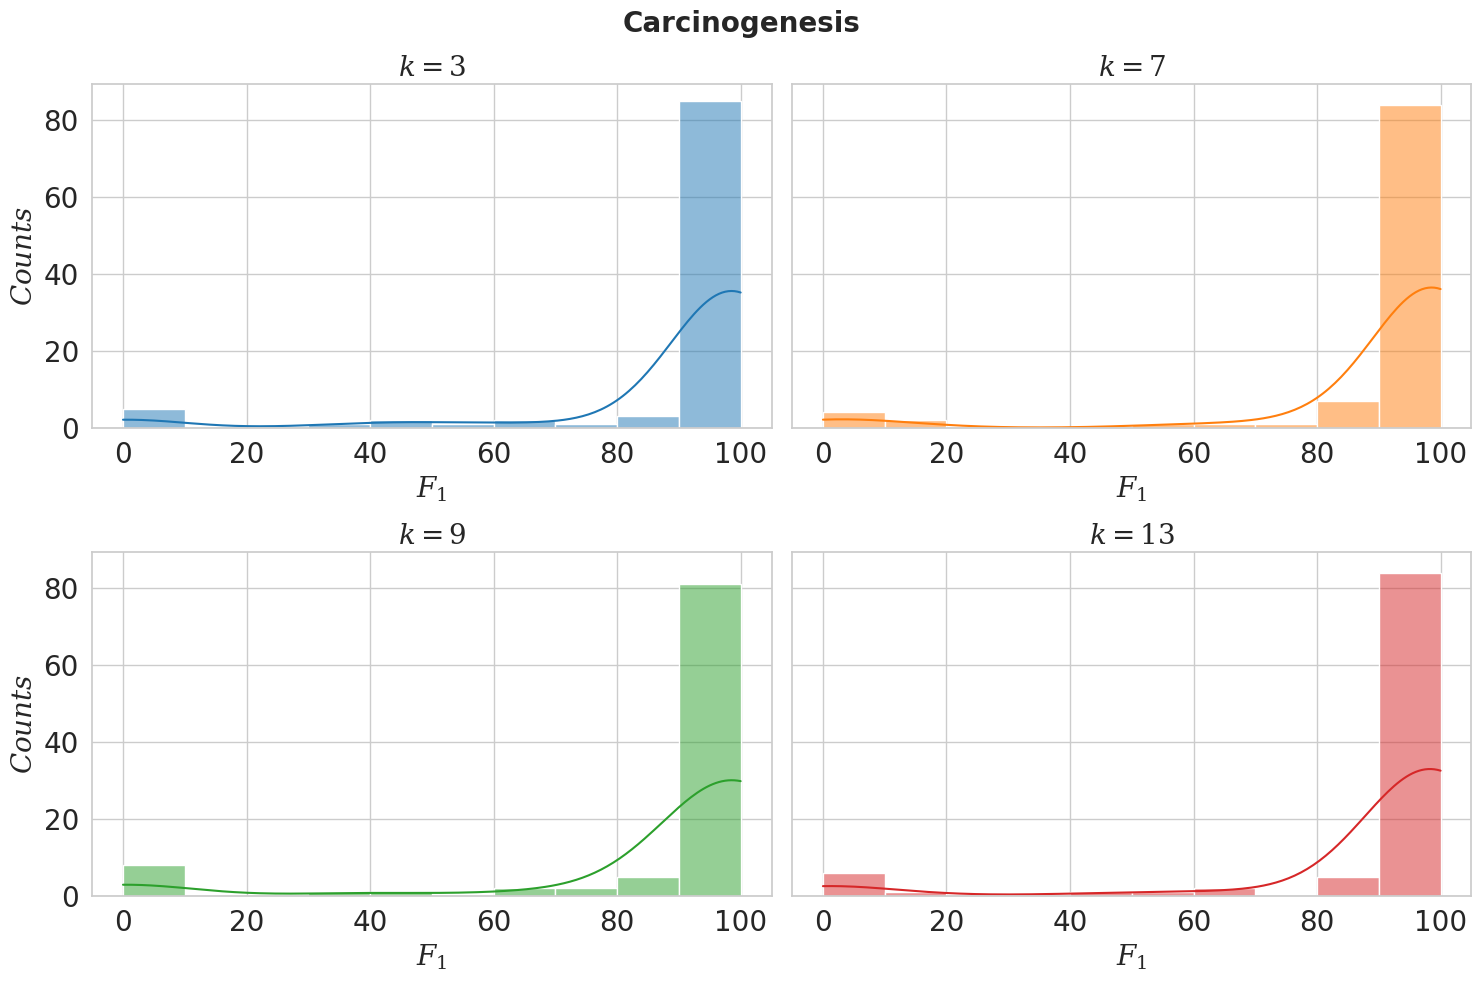

In [28]:
plot_results(results)

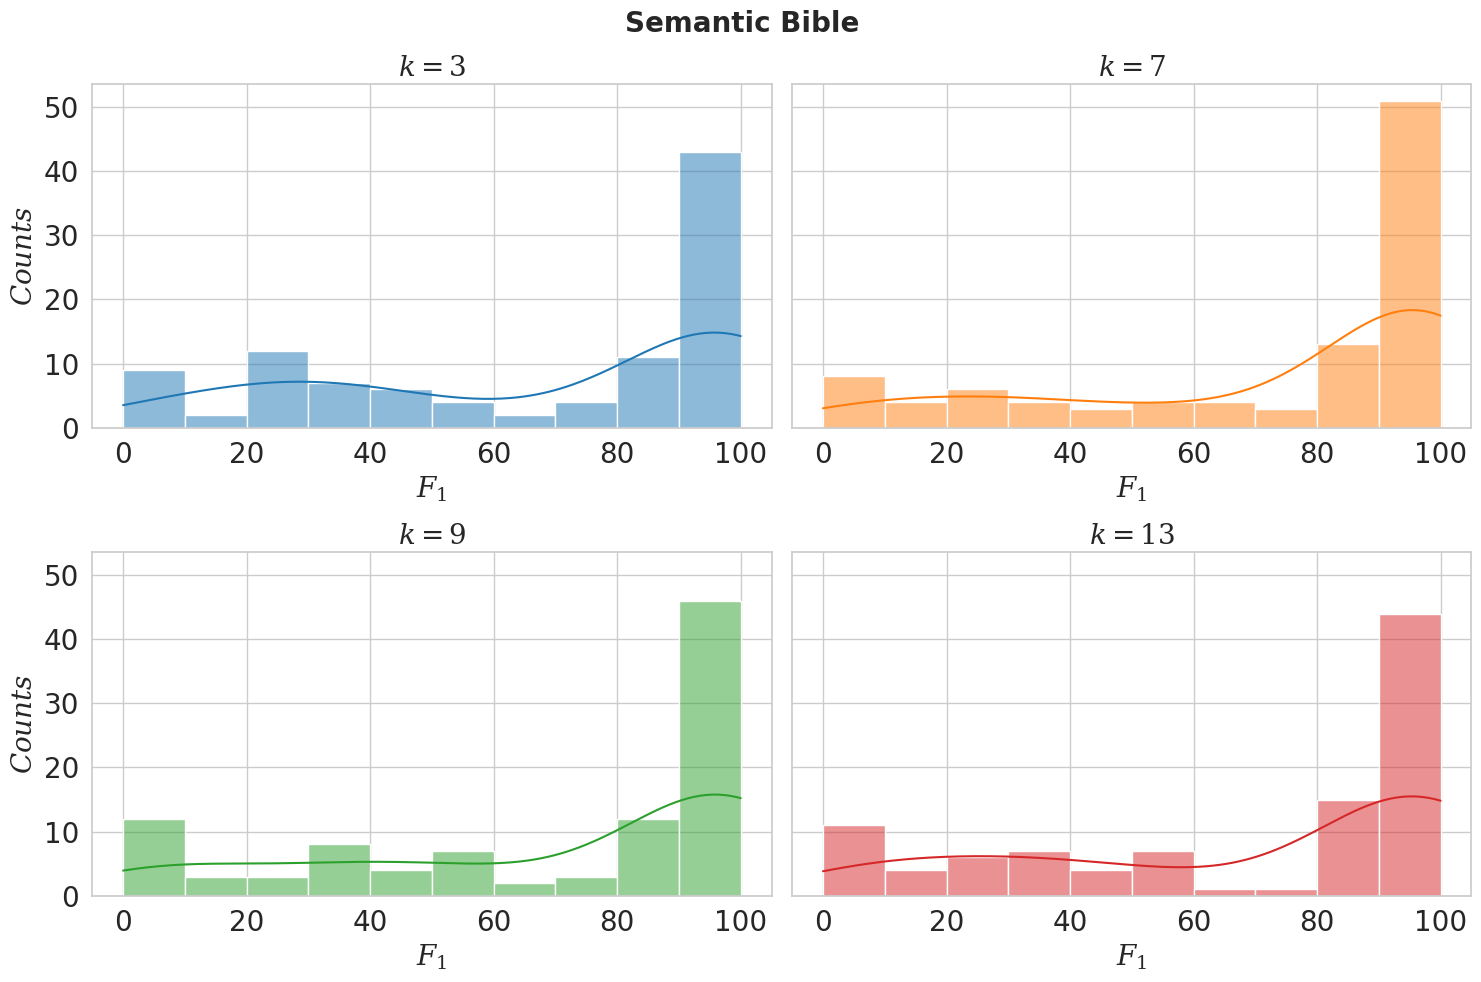

In [29]:
plot_results(results, kb_name="semantic_bible")

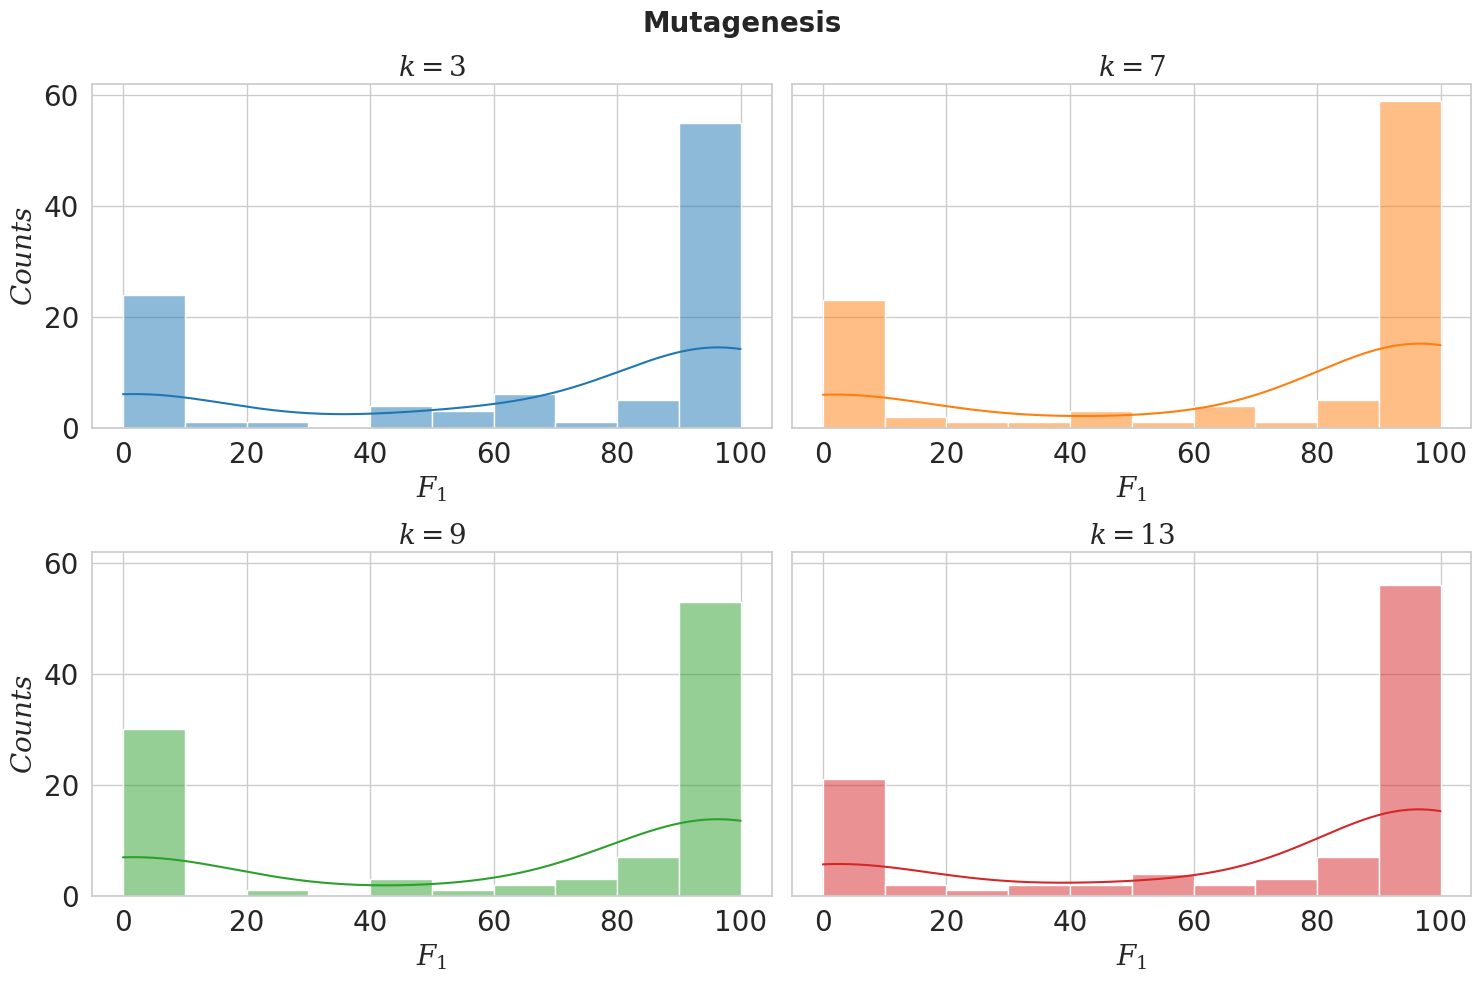

In [30]:
plot_results(results, kb_name="mutagenesis")

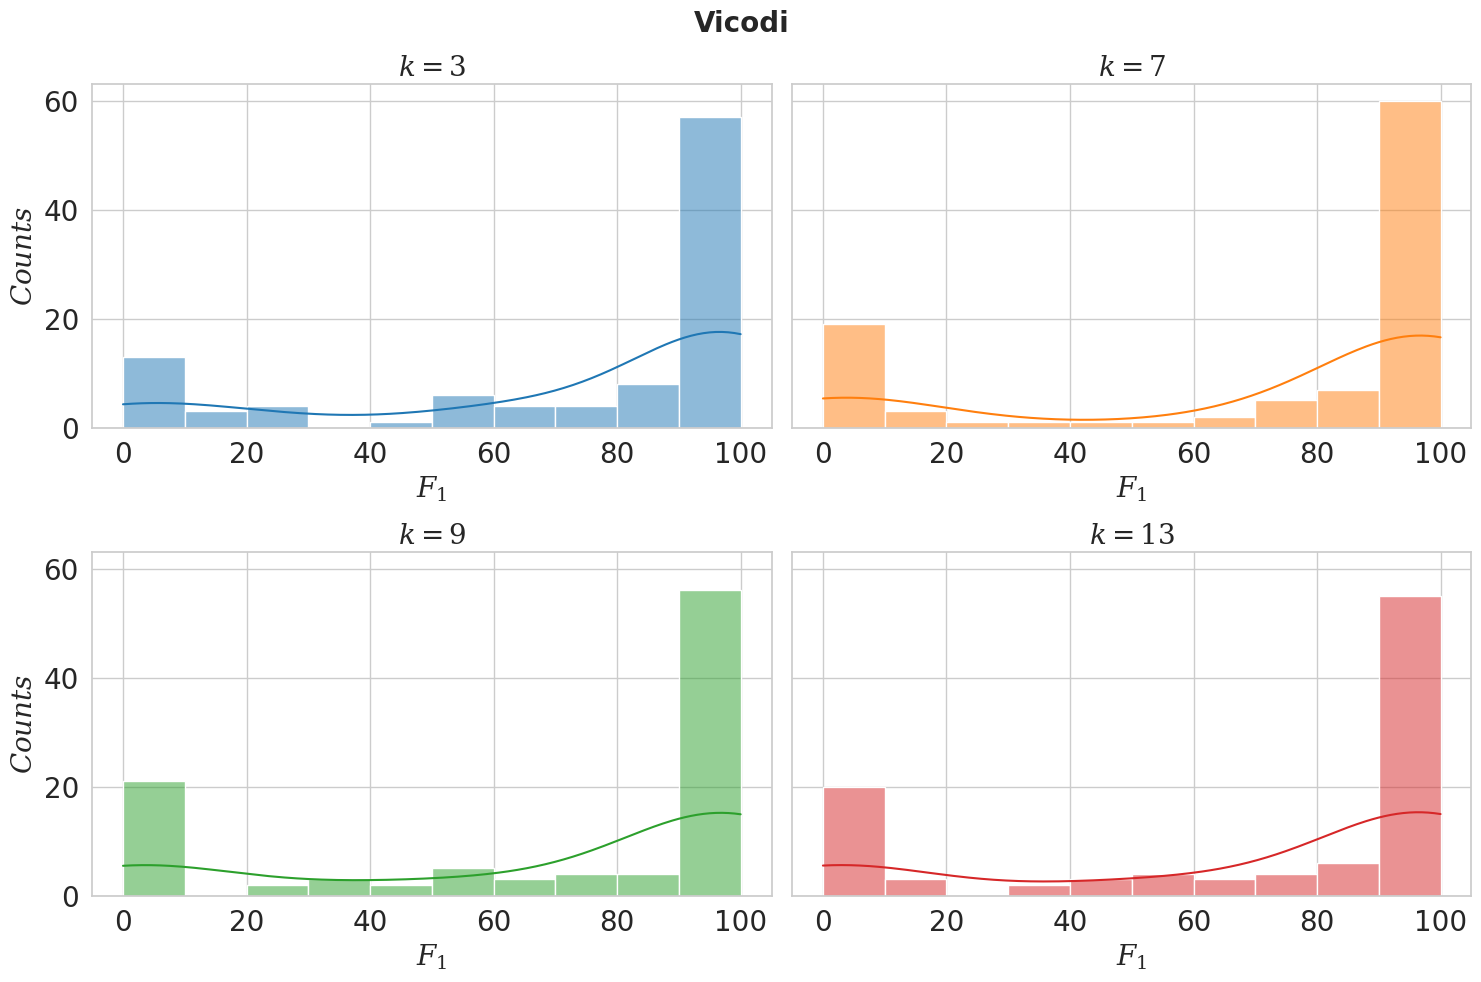

In [31]:
plot_results(results, kb_name="vicodi")